In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import read_quote      as rq
import stock_functions as sf
import df_visualizations as dv
import remap_values as rv

import random
import pickle

import sys
import time

In [15]:
from sklearn.svm            import SVR
from sklearn.ensemble       import RandomForestRegressor
from sklearn.linear_model   import ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble       import BaggingRegressor

from sklearn.utils          import shuffle

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.multioutput    import MultiOutputRegressor

In [3]:
%matplotlib inline
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (14, 10)

In [4]:
roll_nums = [5,15]#[3,5,7,10,12,15,18,20,22,25,28,30] # Generate an algorithm for predicting every few days
mom_nums  = [3,5,10,20,30]                     # Momentum has many good tracers
rsi_nums  = [10,15]                            # Good for some long term trends
band_nums = [5,10,15,20,25]                    # A few trace different areas well

In [5]:
inpFileList = ['aapl','acm' ,'awk' ,'amzn','awr' ,'ba'  ,'bac' ,'c'   ,'cat' ,'cop' ,'cvx' ,'dal' ,
               'dd'  ,'farm','fdp' ,'gnc' ,'hes' ,'ibm' ,'mas' ,'mcd' ,'mon' ,'msex','msft','nflx',
               'sbux','strl','tgt' ,'tsla','ups' ,'xom' ,'xpo' ,'vmc' ]

In [6]:
scaled_df = sf.get_scaled_data( inpFileList, roll_nums, mom_nums, rsi_nums, band_nums )

In [2]:
# Read in each stock, and perform reduction
#    Break into train, test sets
#    Store train, test sets in arrays
# For each regressor predicting a certain num of days...
#    Manually cross validate, testing and scoring each set

In [79]:
def reduced_chi_squared( inp1, inp2 ):
    if ( len(inp1) != len(inp2) ):
        print 'Shape mismatch in MeanSquaredError: %i %i' % ( len(inp1), len(inp2) )
        sys.exit()
    total = 0
    std   = inp1.std()
    for i in range( 0, len(inp1) ):
        total = total + ( inp1[i] - inp2[i] )**2
    return total/( std**2 * ( len(inp1) - 1 ) )

In [10]:
print n_train, shuff_scaled_df.shape

54425 (77750, 24)


In [12]:
# Mix up the list
shuff_scaled_df = shuffle( scaled_df, random_state=0 )

n_elements = shuff_scaled_df.shape[0]

# Set the fraction of data we will train over
percent_train = 0.7

# Size of training set
n_train = int( percent_train * n_elements )

train_df = shuff_scaled_df[ :  n_train   ]
test_df  = shuff_scaled_df[    n_train : ]

In [18]:
train_x = train_df.dropna().drop( ['close','close_mean_5','close_mean_15'] ).values
test_x  =  test_df.dropna().drop( ['close','close_mean_5','close_mean_15'] ).values

train_y = train_df.dropna()['close_mean_15'].values
test_y  =  test_df.dropna()['close_mean_15'].values

In [20]:
params = { 
            'hidden_layer_sizes':[(10,),(20,),(50,),(100,)],
            'alpha':[1e-6,1e-4,1e-2]
         }

nn_reg = GridSearchCV( MLPRegressor(), param_grid=params )
nn_reg.fit( train_x, train_y )
print nn_reg.best_score_
print nn_reg.best_params_

0.920900937902
{'alpha': 0.01, 'hidden_layer_sizes': (100,)}


In [22]:
params = { 
           'n_estimators'      : [30,50,70],
           'min_samples_split' : [2,5,10,20]
         }

rf_reg = GridSearchCV( RandomForestRegressor(), param_grid=params )
rf_reg.fit( train_x, train_y )
print rf_reg.best_score_
print rf_reg.best_params_

0.999926994108
{'min_samples_split': 2, 'n_estimators': 50}


In [23]:
params = { 
            'n_estimators' : [10,20,30]
         }

ba_reg = GridSearchCV( BaggingRegressor(), param_grid=params )
ba_reg.fit( train_x, train_y )
print ba_reg.best_score_
print ba_reg.best_params_

0.999927083261
{'n_estimators': 30}


In [24]:
params = { 
            'alpha' : [0.25,0.5,0.75,1.0],
            'l1_ratio': [0.15,0.4,0.6,0.8]
         }

en_reg = GridSearchCV( ElasticNet(), param_grid=params )
en_reg.fit( train_x, train_y )
print en_reg.best_score_
print en_reg.best_params_

-0.000110706178723
{'alpha': 0.25, 'l1_ratio': 0.15}


In [26]:
params = {  
            'kernel':['linear'],
            'C' : [1e-1,1e0],
            'gamma': [1e-4,1e-3]
         }

sv_reg = GridSearchCV( SVR(), param_grid=params )
sv_reg.fit( train_x, train_y )
print sv_reg.best_score_
print sv_reg.best_params_

0.843521872784
{'kernel': 'linear', 'C': 0.1, 'gamma': 0.0001}


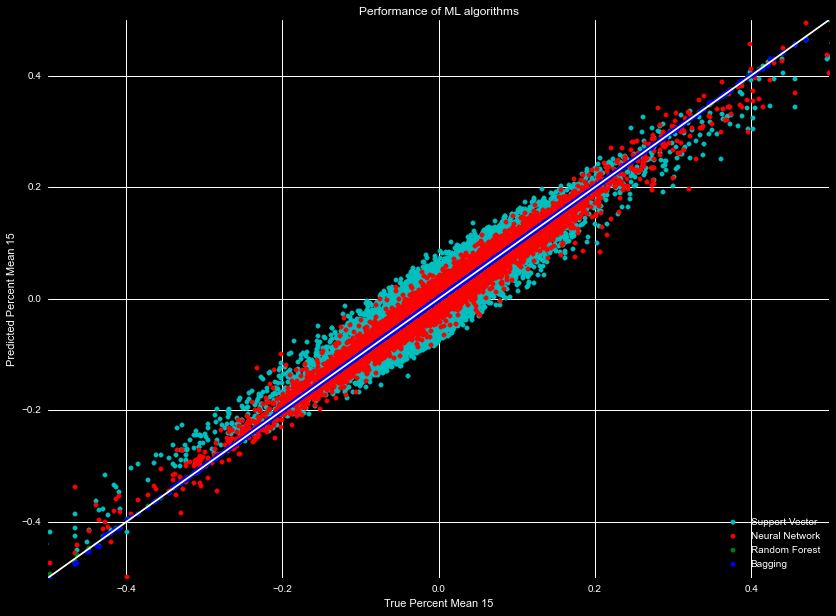

In [29]:
# Plot the data
nn_y = nn_reg.predict( test_x )
rf_y = rf_reg.predict( test_x )
ba_y = ba_reg.predict( test_x )
sv_y = sv_reg.predict( test_x )



plt.scatter( test_y,  sv_y, color='c', label='Support Vector' )
plt.scatter( test_y,  nn_y, color='r', label='Neural Network' )
plt.scatter( test_y,  rf_y, color='g', label='Random Forest'  )
plt.scatter( test_y,  ba_y, color='b', label='Bagging'        )

low =-0.5
hi  = 0.5

plt.plot( [low,hi], [low,hi], color='w' )

plt.legend( loc=4 )
plt.xlim(low,hi)
plt.ylim(low,hi)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('True Percent Mean 15')
plt.ylabel('Predicted Percent Mean 15')
plt.title('Performance of ML algorithms')
plt.show()

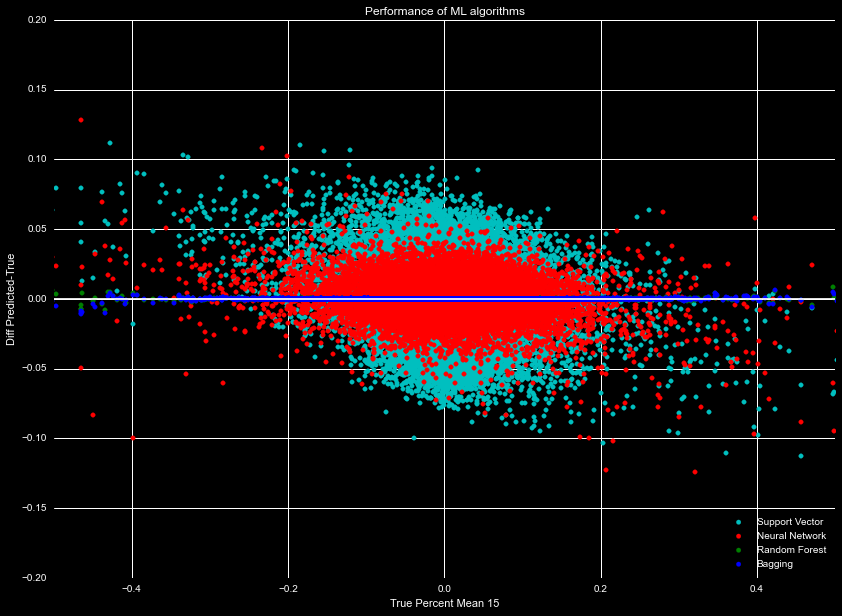

In [35]:
# Plot the data
nn_y = nn_reg.predict( test_x )
rf_y = rf_reg.predict( test_x )
ba_y = ba_reg.predict( test_x )
sv_y = sv_reg.predict( test_x )



plt.scatter( test_y,  sv_y-test_y, color='c', label='Support Vector' )
plt.scatter( test_y,  nn_y-test_y, color='r', label='Neural Network' )
plt.scatter( test_y,  rf_y-test_y, color='g', label='Random Forest'  )
plt.scatter( test_y,  ba_y-test_y, color='b', label='Bagging'        )

low =-0.5
hi  = 0.5

plt.plot( [low,hi], [0,0], color='w' )

plt.legend( loc=4 )
plt.xlim(low,hi)
plt.ylim(-0.2,0.2)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('True Percent Mean 15')
plt.ylabel('Diff Predicted-True')
plt.title('Performance of ML algorithms')
plt.show()

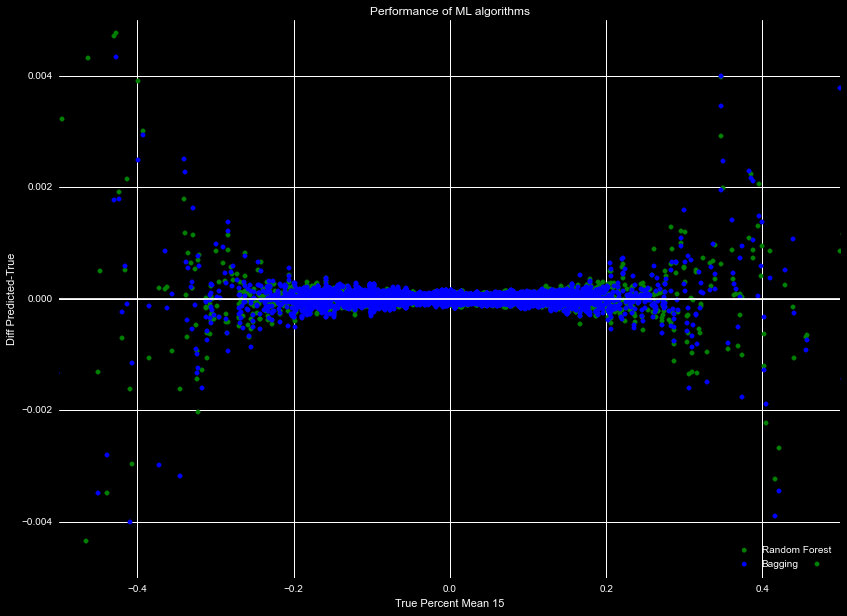

In [36]:
# Plot the data
rf_y = rf_reg.predict( test_x )
ba_y = ba_reg.predict( test_x )



plt.scatter( test_y,  rf_y-test_y, color='g', label='Random Forest'  )
plt.scatter( test_y,  ba_y-test_y, color='b', label='Bagging'        )

low =-0.5
hi  = 0.5

plt.plot( [low,hi], [0,0], color='w' )

plt.legend( loc=4 )
plt.xlim(low,hi)
plt.ylim(-0.005,0.005)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('True Percent Mean 15')
plt.ylabel('Diff Predicted-True')
plt.title('Performance of ML algorithms')
plt.show()

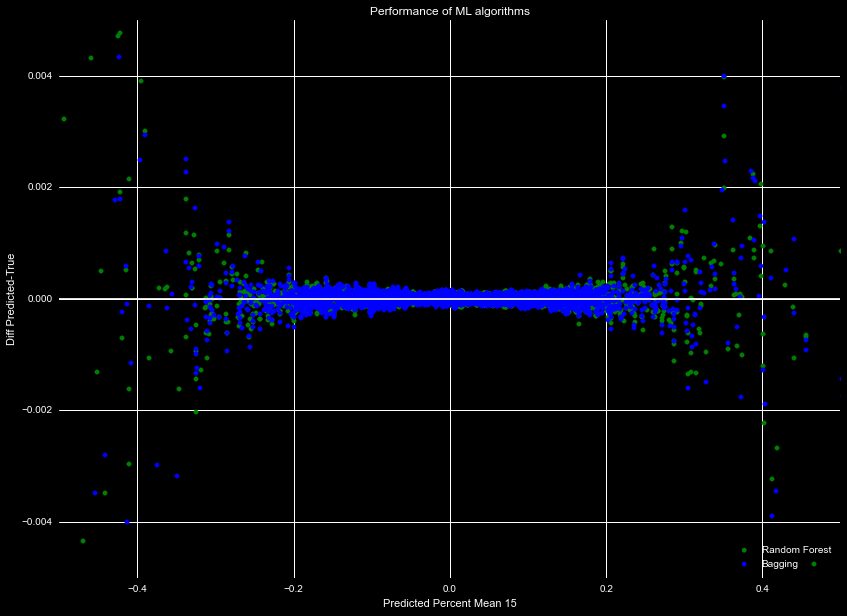

In [39]:
# Plot the data
rf_y = rf_reg.predict( test_x )
ba_y = ba_reg.predict( test_x )



plt.scatter( rf_y,  rf_y-test_y, color='g', label='Random Forest'  )
plt.scatter( ba_y,  ba_y-test_y, color='b', label='Bagging'        )

low =-0.5
hi  = 0.5

plt.plot( [low,hi], [0,0], color='w' )

plt.legend( loc=4 )
plt.xlim(low,hi)
plt.ylim(-0.005,0.005)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Predicted Percent Mean 15')
plt.ylabel('Diff Predicted-True')
plt.title('Performance of ML algorithms')
plt.show()

In [261]:
rf_estimators_base = 40 # Increase number of estimators each time
rf_estimators      = rf_estimators_base

#1-4
nn_reg = MLPRegressor          ( hidden_layer_sizes = 200, alpha = 1e-6, learning_rate='adaptive',  tol  =1e-8 , warm_start=True )
rf_reg = RandomForestRegressor ( n_estimators = rf_estimators, min_samples_split = 40 , min_samples_leaf = 30  , warm_start=True )
ba_reg = BaggingRegressor      ( n_estimators = rf_estimators, max_samples       = 0.5, max_features     = 0.5 , warm_start=True )


test_list = []

# loop over all the training and testing stuffs 
for i in range( 0, len(quote_list) ):

    
    ###########################################
    ########Seperate train/test data###########
    ###########################################
    
    big_df = quote_list[i]
    
    # Break up train and test sets
    n_train = int( big_df.shape[0] * percent_train )

    # Split the train and test data
    
    train_df =        big_df[:n_train ]
    test_list.append( big_df[ n_train:] )

    
    # Pure set of y and x data
    # Need to trim bad values
    y_df = train_df     [   target_list         ]
    x_df = train_df.drop(   target_list, axis=1 )

    
# loop over target list    
    target_col = target_list[-1]
    
    # Drops rows containing na
    x_train = y_df[target_col].dropna().to_frame().join( x_df, how='inner' ).drop( target_col, axis=1 ).values
    y_train = y_df[target_col].dropna().values


    # Update number of trees
    rf_reg.set_params( n_estimators=rf_estimators )
    ba_reg.set_params( n_estimators=rf_estimators )

    # Increase the number of trees for next time
    rf_estimators = rf_estimators + rf_estimators_base

    nn_reg.fit( x_train, y_train )
    rf_reg.fit( x_train, y_train )
    ba_reg.fit( x_train, y_train )

#    print 'Neural Network chi^2 internal accuracy of : %7.4f' % ( reduced_chi_squared( nn_reg.predict( x_train ), y_train ) )
#    print 'Random Forest  chi^2 internal accuracy of : %7.4%' % ( reduced_chi_squared( rf_reg.predict( x_train ), y_train ) )
#    print 'Bagging        chi^2 internal accuracy of : %7.4%' % ( reduced_chi_squared( ba_reg.predict( x_train ), y_train ) )
#    print ''

    
    
# Test and validate
tot_nn_chi2 = 0
tot_rf_chi2 = 0
tot_ba_chi2 = 0

for test_df in test_list:
    
    y_df = test_df     [   target_list         ]
    x_df = test_df.drop(   target_list, axis=1 )

    
# loop over target list    
    target_col = target_list[-1]
    
    # Drops rows containing na
    x_test = y_df[target_col].dropna().to_frame().join( x_df, how='inner' ).drop( target_col, axis=1 ).values
    y_test = y_df[target_col].dropna().values

    nn_chi2 = reduced_chi_squared( nn_reg.predict( x_test ), y_test )
    rf_chi2 = reduced_chi_squared( rf_reg.predict( x_test ), y_test )
    ba_chi2 = reduced_chi_squared( ba_reg.predict( x_test ), y_test )
    
#    print 'Neural Network chi^2 fit accuracy of : %7.4f' % ( nn_chi2 )
#    print 'Random Forest  chi^2 fit accuracy of : %7.4f' % ( rf_chi2 )
#    print 'Bagging        chi^2 fit accuracy of : %7.4f' % ( ba_chi2 )

    tot_nn_chi2 += nn_chi2
    tot_rf_chi2 += rf_chi2
    tot_ba_chi2 += ba_chi2

print ' '
print 'Total Neural Network chi2: %7.4f' % ( tot_nn_chi2/len(test_list) )
print 'Total Random Forest  chi2: %7.4f' % ( tot_rf_chi2/len(test_list) )
print 'Total Bagging        chi2: %7.4f' % ( tot_ba_chi2/len(test_list) )
#bn_reg.set_params( base_estimator__learning_rate='adaptive' )

 
Total Neural Network chi2:  2.6072
Total Random Forest  chi2:  1.9427
Total Bagging        chi2:  2.0531


In [71]:
plot_frame = pd.DataFrame( {'true':target_values} )
plot_frame['random_forest' ] = rf_reg.predict( variable_values ) - plot_frame['true']
plot_frame['neural_network'] = nn_reg.predict( variable_values ) - plot_frame['true']
plot_frame['bagging'       ] = ba_reg.predict( variable_values ) - plot_frame['true']
plot_frame['average'       ] = (plot_frame['random_forest' ]+
                                plot_frame['bagging'       ]+
                                plot_frame['neural_network'])/3

In [72]:
ll   = 0.5
reg1 = 'random_forest'
reg2 = 'neural_network'
reg3 = 'bagging'
reg4 = 'average'

ax1 = plot_frame.plot(kind='scatter', x='true', y=reg1, color='g', alpha=0.3, label=reg1 )    
ax2 = plot_frame.plot(kind='scatter', x='true', y=reg2, color='r', alpha=0.3, label=reg2, ax=ax1)
ax3 = plot_frame.plot(kind='scatter', x='true', y=reg3, color='b', alpha=0.3, label=reg3, ax=ax1)
ax4 = plot_frame.plot(kind='scatter', x='true', y=reg4, color='k', alpha=0.3, label=reg4, ax=ax1)

#ax1.plot( [-ll,ll], [-ll,ll], color='k' )
ax1.set_ybound( [-ll,ll] )
ax1.set_xlabel( 'True Value' )
ax1.set_ylabel( 'predicted-true' )
ax1.legend( loc=2 )

plt.show()